Imports

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import sys
from random import shuffle

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.append('D:\Study\Applied Programming (Python)\Applied-Programming\Lab4')
from df_works import df_build, lemmatize_text

A function that adds a new column to dataset setting labels based on what rating is considered favourable 

In [27]:
def binarize(data: pd.DataFrame, rating: int) -> pd.DataFrame:
    data.dropna(inplace=True)
    change_labels = lambda x: 1 if x==rating else 0
    data['Label'] = data['Rating'].apply(change_labels)
    return data

Create dataframe and lemmatize the review texts inside

In [37]:
data = df_build('D:\Study\Applied Programming (Python)\Applied-Programming\Lab2\csv\dataset.csv')

remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)
data = lemmatize_text(data)
data = binarize(data, 5)

Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatized
Token lemmatiz

In [28]:
max_words = 1000
cv = CountVectorizer(max_features=max_words, stop_words=stopwords.words('russian'))
sparse_matrix = cv.fit_transform(data['Review text']).toarray()
l = len(sparse_matrix)
print(sparse_matrix)
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['Label']))
x_train, x_val, y_train, y_val = train_test_split(sparse_matrix, np.array(data['Label']))
print(x_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Logistic regression

In [29]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(1000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [30]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_val)).float()
y_valid = Variable(torch.from_numpy(y_val)).long()

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)


In [31]:
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
epochs = 20
loss_values, models = [], []

Epoch 1/20, Training Loss: 0.7329, Training Accuracy: 0.2857, Validation Loss: 0.7841, Validation Accuracy: 0.1667
Epoch 2/20, Training Loss: 0.7028, Training Accuracy: 0.2857, Validation Loss: 0.7730, Validation Accuracy: 0.2500
Epoch 3/20, Training Loss: 0.6866, Training Accuracy: 0.4286, Validation Loss: 0.7597, Validation Accuracy: 0.2500
Epoch 4/20, Training Loss: 0.6138, Training Accuracy: 0.6286, Validation Loss: 0.7456, Validation Accuracy: 0.1667
Epoch 5/20, Training Loss: 0.6127, Training Accuracy: 0.8571, Validation Loss: 0.7302, Validation Accuracy: 0.3333
Epoch 6/20, Training Loss: 0.5984, Training Accuracy: 0.9143, Validation Loss: 0.7139, Validation Accuracy: 0.3333
Epoch 7/20, Training Loss: 0.4976, Training Accuracy: 0.9143, Validation Loss: 0.6981, Validation Accuracy: 0.5000
Epoch 8/20, Training Loss: 0.5208, Training Accuracy: 0.9143, Validation Loss: 0.6819, Validation Accuracy: 0.5000
Epoch 9/20, Training Loss: 0.4383, Training Accuracy: 0.9429, Validation Loss: 0

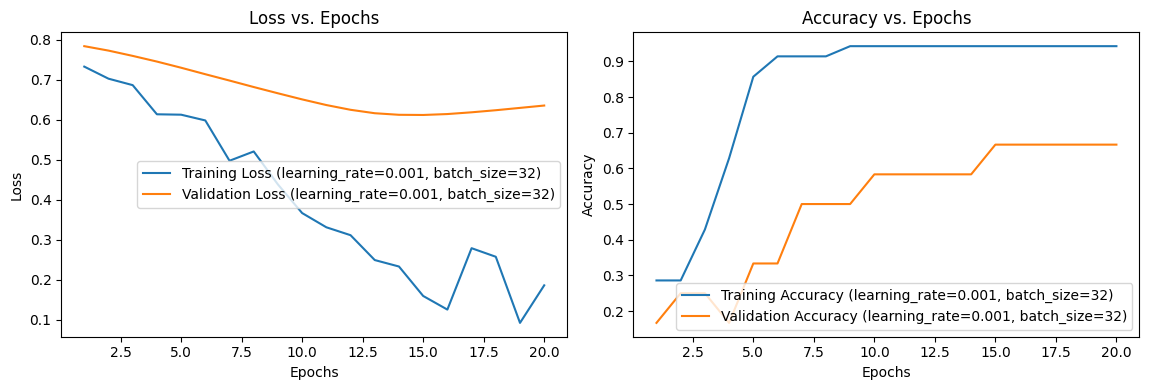

Epoch 1/20, Training Loss: 0.1330, Training Accuracy: 0.9429, Validation Loss: 0.6451, Validation Accuracy: 0.7500
Epoch 2/20, Training Loss: 0.1244, Training Accuracy: 0.9714, Validation Loss: 0.6523, Validation Accuracy: 0.7500
Epoch 3/20, Training Loss: 0.1160, Training Accuracy: 0.9714, Validation Loss: 0.6601, Validation Accuracy: 0.7500
Epoch 4/20, Training Loss: 0.1086, Training Accuracy: 0.9714, Validation Loss: 0.6695, Validation Accuracy: 0.7500
Epoch 5/20, Training Loss: 0.1019, Training Accuracy: 0.9714, Validation Loss: 0.6794, Validation Accuracy: 0.7500
Epoch 6/20, Training Loss: 0.0958, Training Accuracy: 0.9714, Validation Loss: 0.6897, Validation Accuracy: 0.7500
Epoch 7/20, Training Loss: 0.0901, Training Accuracy: 0.9714, Validation Loss: 0.7001, Validation Accuracy: 0.7500
Epoch 8/20, Training Loss: 0.0849, Training Accuracy: 1.0000, Validation Loss: 0.7105, Validation Accuracy: 0.7500
Epoch 9/20, Training Loss: 0.0801, Training Accuracy: 1.0000, Validation Loss: 0

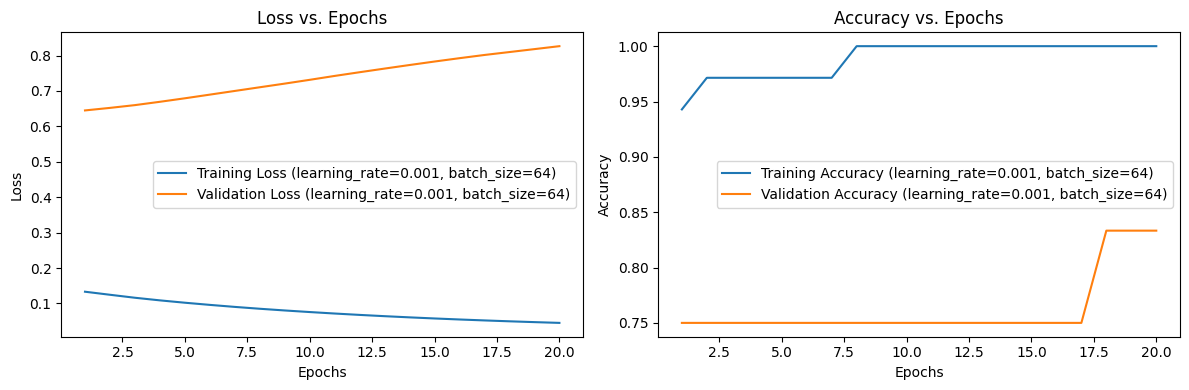

Epoch 1/20, Training Loss: 0.0430, Training Accuracy: 1.0000, Validation Loss: 0.8653, Validation Accuracy: 0.8333
Epoch 2/20, Training Loss: 0.0408, Training Accuracy: 1.0000, Validation Loss: 0.8898, Validation Accuracy: 0.8333
Epoch 3/20, Training Loss: 0.0385, Training Accuracy: 1.0000, Validation Loss: 0.9122, Validation Accuracy: 0.8333
Epoch 4/20, Training Loss: 0.0365, Training Accuracy: 1.0000, Validation Loss: 0.9337, Validation Accuracy: 0.8333
Epoch 5/20, Training Loss: 0.0347, Training Accuracy: 1.0000, Validation Loss: 0.9530, Validation Accuracy: 0.8333
Epoch 6/20, Training Loss: 0.0329, Training Accuracy: 1.0000, Validation Loss: 0.9710, Validation Accuracy: 0.8333
Epoch 7/20, Training Loss: 0.0313, Training Accuracy: 1.0000, Validation Loss: 0.9877, Validation Accuracy: 0.8333
Epoch 8/20, Training Loss: 0.0298, Training Accuracy: 1.0000, Validation Loss: 1.0044, Validation Accuracy: 0.8333
Epoch 9/20, Training Loss: 0.0284, Training Accuracy: 1.0000, Validation Loss: 1

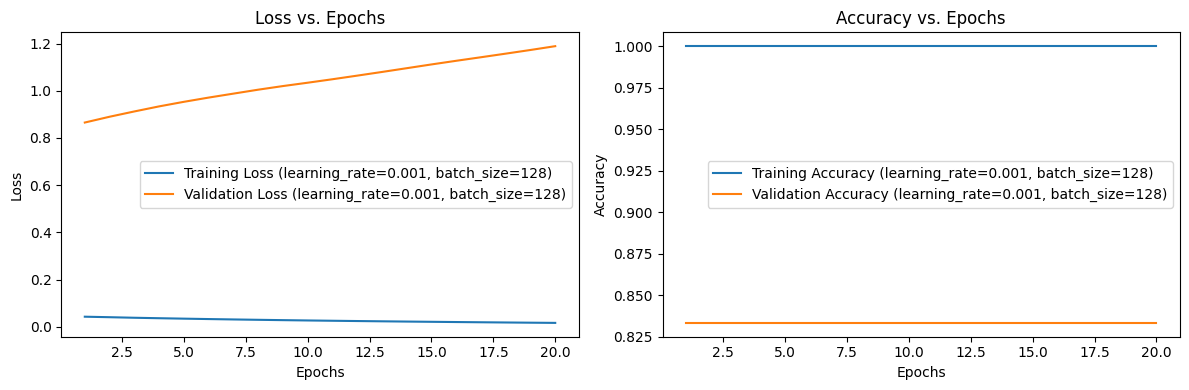

Epoch 1/20, Training Loss: 0.0087, Training Accuracy: 1.0000, Validation Loss: 1.4896, Validation Accuracy: 0.8333
Epoch 2/20, Training Loss: 0.0081, Training Accuracy: 1.0000, Validation Loss: 1.6181, Validation Accuracy: 0.8333
Epoch 3/20, Training Loss: 0.0009, Training Accuracy: 1.0000, Validation Loss: 1.7615, Validation Accuracy: 0.8333
Epoch 4/20, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Loss: 1.8753, Validation Accuracy: 0.8333
Epoch 5/20, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Loss: 1.9667, Validation Accuracy: 0.8333
Epoch 6/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 2.0391, Validation Accuracy: 0.8333
Epoch 7/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 2.0971, Validation Accuracy: 0.8333
Epoch 8/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 2.1442, Validation Accuracy: 0.8333
Epoch 9/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 2

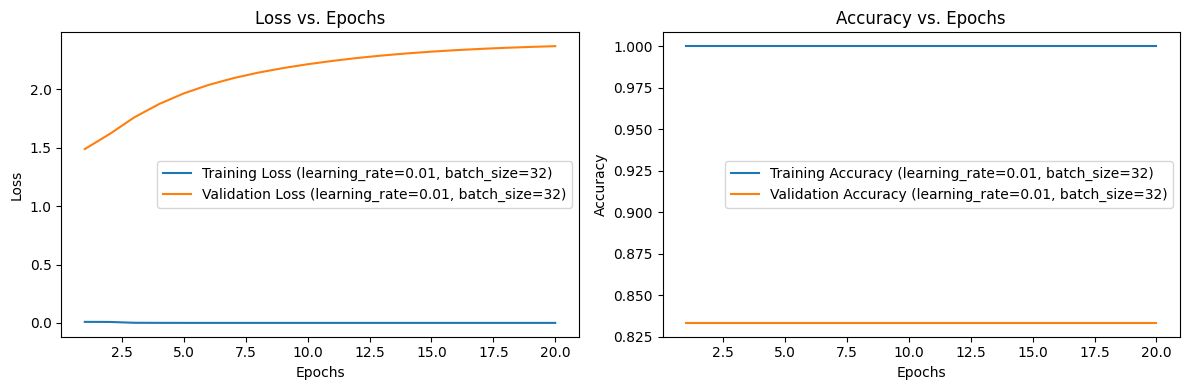

Epoch 1/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 2.7910, Validation Accuracy: 0.8333
Epoch 2/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.1539, Validation Accuracy: 0.8333
Epoch 3/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.4315, Validation Accuracy: 0.8333
Epoch 4/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.6296, Validation Accuracy: 0.8333
Epoch 5/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.7648, Validation Accuracy: 0.8333
Epoch 6/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.8551, Validation Accuracy: 0.8333
Epoch 7/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.9168, Validation Accuracy: 0.8333
Epoch 8/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.9611, Validation Accuracy: 0.8333
Epoch 9/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3

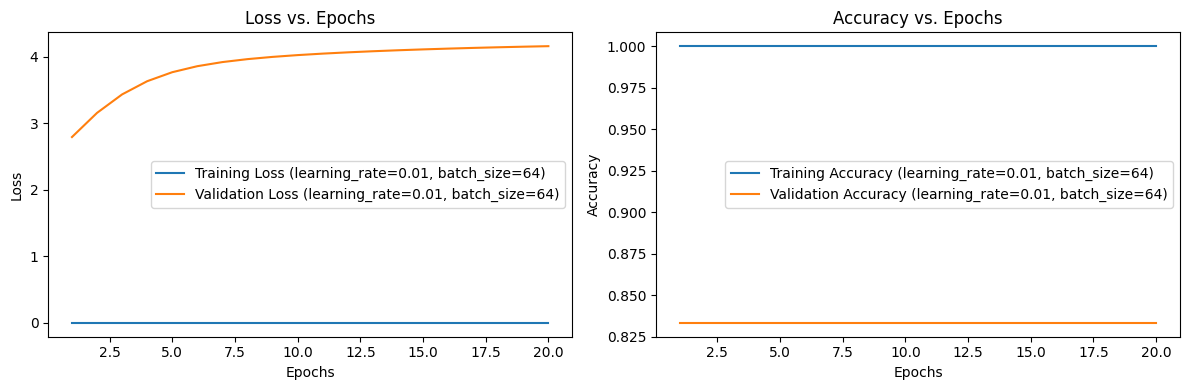

Epoch 1/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1543, Validation Accuracy: 0.8333
Epoch 2/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1529, Validation Accuracy: 0.8333
Epoch 3/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1515, Validation Accuracy: 0.8333
Epoch 4/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1502, Validation Accuracy: 0.8333
Epoch 5/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1488, Validation Accuracy: 0.8333
Epoch 6/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1474, Validation Accuracy: 0.8333
Epoch 7/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1461, Validation Accuracy: 0.8333
Epoch 8/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1448, Validation Accuracy: 0.8333
Epoch 9/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4

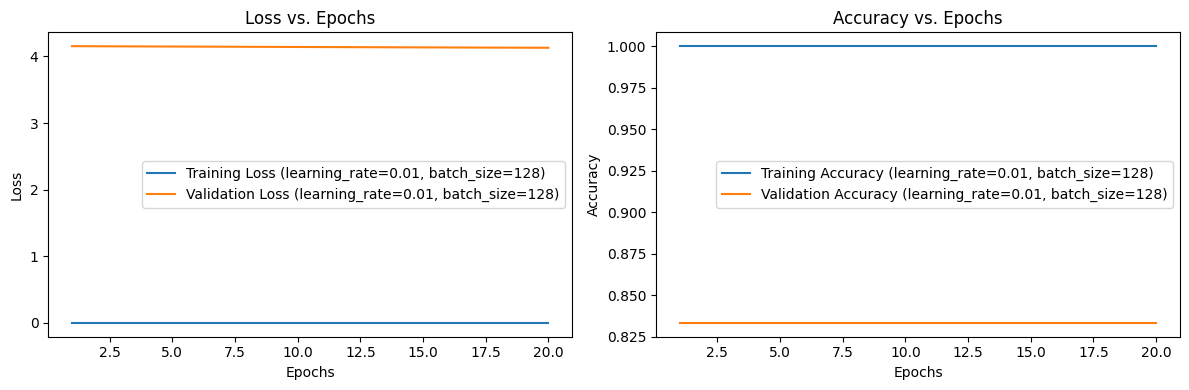

Epoch 1/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1142, Validation Accuracy: 0.8333
Epoch 2/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1032, Validation Accuracy: 0.8333
Epoch 3/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0941, Validation Accuracy: 0.8333
Epoch 4/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0861, Validation Accuracy: 0.8333
Epoch 5/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0787, Validation Accuracy: 0.8333
Epoch 6/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0721, Validation Accuracy: 0.8333
Epoch 7/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0688, Validation Accuracy: 0.8333
Epoch 8/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0681, Validation Accuracy: 0.8333
Epoch 9/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4

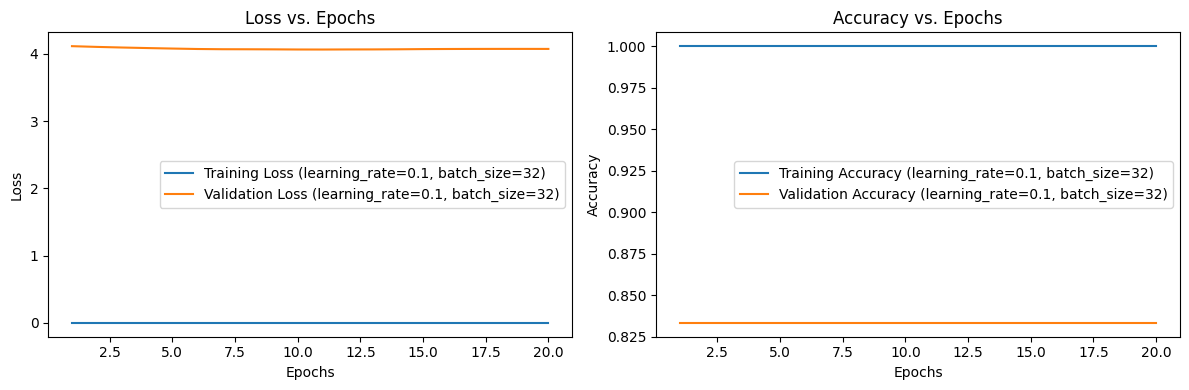

Epoch 1/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0721, Validation Accuracy: 0.8333
Epoch 2/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0710, Validation Accuracy: 0.8333
Epoch 3/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0699, Validation Accuracy: 0.8333
Epoch 4/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0688, Validation Accuracy: 0.8333
Epoch 5/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0678, Validation Accuracy: 0.8333
Epoch 6/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0668, Validation Accuracy: 0.8333
Epoch 7/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0658, Validation Accuracy: 0.8333
Epoch 8/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0648, Validation Accuracy: 0.8333
Epoch 9/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4

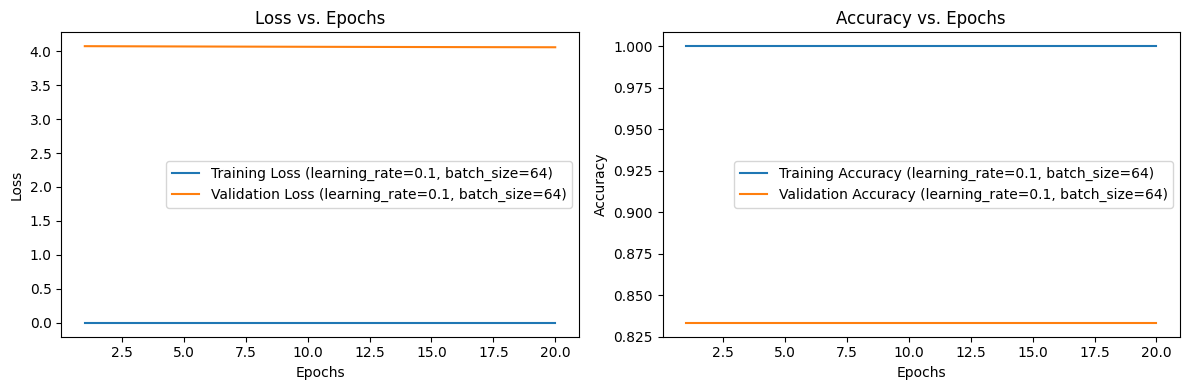

Epoch 1/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0558, Validation Accuracy: 0.8333
Epoch 2/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0555, Validation Accuracy: 0.8333
Epoch 3/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0552, Validation Accuracy: 0.8333
Epoch 4/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0549, Validation Accuracy: 0.8333
Epoch 5/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0546, Validation Accuracy: 0.8333
Epoch 6/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0544, Validation Accuracy: 0.8333
Epoch 7/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0541, Validation Accuracy: 0.8333
Epoch 8/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.0539, Validation Accuracy: 0.8333
Epoch 9/20, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4

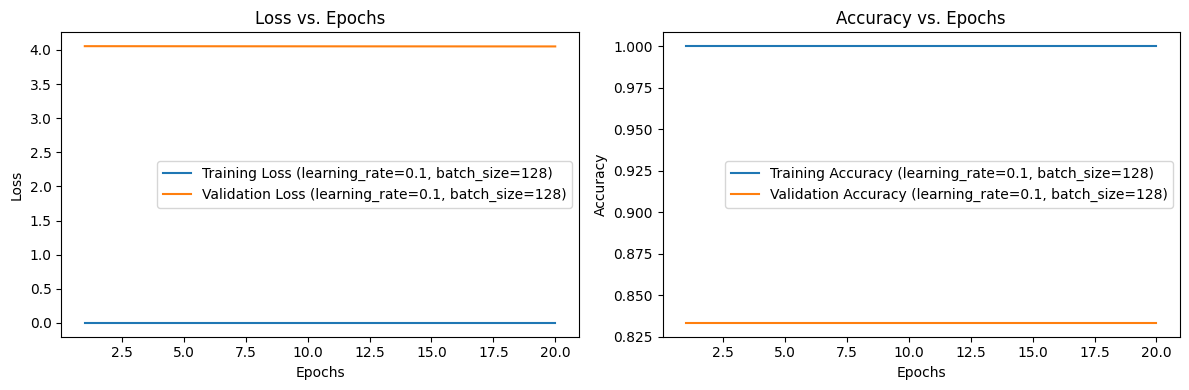

Test Accuracy: 1.0000


In [36]:
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []
        for epoch in range(epochs):
            model.train()

            cur_loss = 0.0
            correct_guesses = 0
            total_guesses = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                cur_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_guesses += labels.size(0)
                correct_guesses += (predicted == labels).sum().item()

            train_losses.append(cur_loss / len(train_loader))
            train_accuracy.append(correct_guesses / total_guesses)

            # Validation
            model.eval()

            cur_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    cur_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(cur_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)

                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        # Visualization
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (learning_rate={learning_rate}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (learning_rate={learning_rate}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (learning_rate={learning_rate}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (learning_rate={learning_rate}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epochs')

        plt.tight_layout()
        plt.show()

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')